## Network definition and training

In [81]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Trains here a very simple classifier for bottleneck features of VGG16.
#It usually performs really bad, the goal being to get initialization weights
#for the "final" training

#Dimensions of our images.
#Note : some images may have to be redimensioned
img_width, img_height = 116, 116

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = './img/train'
validation_data_dir = './img/validation'
nb_train_samples = 7104 + 7088
nb_validation_samples = 1280
epochs = 500
#Restricted batch size, because of memory issues
#Preferably, the batch size should be increased
batch_size = 256


def save_bottleneck_features():
    #Note : saving the bottleneck features can actually take quite some time
    print('Save...')
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    #The pre-trained model predicts the representations of the images, to (warm) train the classifier
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    print(bottleneck_features_train.shape)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    print(bottleneck_features_validation.shape)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_top_model():
    print('Train...')
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * 7088 + [1] * 7104)

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256))
    #Dropout might be augmented if too much overfitting occurs
    model.add(Dropout(0.1))
    model.add(Dense(1024, activation = 'relu'))

    model.add(Dense(1, activation='sigmoid'))

    print('Compiling...')
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])
    callbacks = []
    callbacks.append(
        ModelCheckpoint(top_model_weights_path,
                        monitor='val_loss', verbose=1,
                        save_best_only=True, save_weights_only=True,
                        mode='auto', period=1))
    # add early stopping
    callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0.001,
                                   patience=10, verbose=1))

    # reduce learning-rate when reaching plateau
    callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                       patience=5, epsilon=0.001,cooldown=2, verbose=1))


    print('Fitting...')
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              callbacks = callbacks,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


In [82]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
im = cv2.imread('./img/train/Blend/Stamp-0.jpg')
print(im.shape)

(116, 116, 3)


### First training part

In [30]:
save_bottleneck_features()

Save...
Found 14192 images belonging to 2 classes.


KeyboardInterrupt: 

In [83]:
train_top_model()

Train...
Compiling...
Fitting...
Train on 14192 samples, validate on 1280 samples
Epoch 1/500
14192/14192 [==============================] - 4s 265us/step - loss: 0.4204 - acc: 0.8162 - val_loss: 1.1585 - val_acc: 0.5062

Epoch 00001: val_loss improved from inf to 1.15847, saving model to bottleneck_fc_model.h5
Epoch 2/500
14192/14192 [==============================] - 2s 149us/step - loss: 0.2217 - acc: 0.9052 - val_loss: 1.7664 - val_acc: 0.5102

Epoch 00002: val_loss did not improve from 1.15847
Epoch 3/500
14192/14192 [==============================] - 3s 213us/step - loss: 0.1841 - acc: 0.9173 - val_loss: 1.8399 - val_acc: 0.4828

Epoch 00003: val_loss did not improve from 1.15847
Epoch 4/500
14192/14192 [==============================] - 3s 214us/step - loss: 0.1785 - acc: 0.9180 - val_loss: 2.4266 - val_acc: 0.5094

Epoch 00004: val_loss did not improve from 1.15847
Epoch 5/500
14192/14192 [==============================] - 3s 226us/step - loss: 0.1512 - acc: 0.9295 - val_loss: 

### Second training part

In [84]:
# path to the model weights files.
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 116, 116

train_data_dir = './img/train'
validation_data_dir = './img/validation'
nb_train_samples = 7104 + 7088
nb_validation_samples = 1280
epochs = 50
batch_size = 16

# build the VGG16 network
input_tensor = Input(shape=(116,116,3))
base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(1024, activation = 'relu'))
top_model.add(Dense(1, activation='sigmoid'))

# We need to use the previous weights to initiate the training
top_model.load_weights(top_model_weights_path)

# Add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# Set the first layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:18]:
    layer.trainable = False

# Compile the model with an Adam optimizer
opt = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['binary_accuracy'])

# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')
    
# create the callbacks to get during fitting
callbacks = []
callbacks.append(
    ModelCheckpoint('./vgg16_weights_best.h5',
                    monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=True,
                    mode='auto', period=1))
# add early stopping
callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0.001,
                               patience=10, verbose=1))
 
# reduce learning-rate when reaching plateau
callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=5, epsilon=0.001,cooldown=2, verbose=1))

model.summary()


# Train the model
model.fit_generator(
    train_generator,
    epochs = epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    steps_per_epoch=nb_train_samples//batch_size
)

#Here, we are going to fine-tune other dense layers of the model.
#This gives slighlty better results, but at the cost of long computation time.
model.layers[19].trainable = False
model.layers[17].trainable = True
    
    
opt = optimizers.SGD(lr=10e-5)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['binary_accuracy'])

model.fit_generator(
    train_generator,
    epochs = epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    steps_per_epoch=nb_train_samples//batch_size
)

#Eventually, fine-tune other conv layers
#model.layers[17].trainable = False
#model.layers[16].trainable = True


#opt = optimizers.SGD(lr=10e-5)
#model.compile(loss='binary_crossentropy',
#              optimizer=opt,
#              metrics=['binary_accuracy'])


#model.fit_generator(
#    train_generator,
#    epochs = epochs,
#    callbacks=callbacks,
#    validation_data=validation_generator,
#    validation_steps=nb_validation_samples//batch_size,
#    steps_per_epoch=nb_train_samples//batch_size
#)


Model loaded.
Found 14192 images belonging to 2 classes.
Found 2569 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 116, 116, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 116, 116, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 116, 116, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 58, 58, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 58, 58, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 58, 58, 128)       147584    
___________________________________________

KeyboardInterrupt: 

In [3]:
#To load the model

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


input_tensor = Input(shape=(116,116,3))
base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(1024, activation = 'relu'))
top_model.add(Dense(1, activation='sigmoid'))


model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.load_weights('./vgg16_weights_best.h5')
model.summary()

58892288/58889256 [==============================] - 64s 1us/step
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 116, 116, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 116, 116, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 116, 116, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 58, 58, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 58, 58, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 58, 58, 128)       147584    
______________________________________________________________

## Testing

In [10]:
#Using the ImageDataGenerator for better handling large datasets

test_datagen = ImageDataGenerator(rescale=1./255)

#Linking to the directory where validation images are stored
test_generator = test_datagen.flow_from_directory(
        './img/test/',
        target_size=(116, 116),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 0 images belonging to 0 classes.


In [8]:
#Get predictions by the generator on the whole dataset
predict = model.predict_generator(test_generator,steps = nb_samples)

In [127]:
#Importing images from jpg to numpy
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join



imgs = []
files1 = ['./img/jpg/Blend/' + f for f in listdir("./img/jpg/Blend/") if isfile(join("./img/jpg/Blend/", f))]
files2 = ['./img/jpg/NoBlend/' + f for f in listdir("./img/jpg/NoBlend/") if isfile(join("./img/jpg/NoBlend/", f))]

files = files1 + files2

for img in files :
    imgs.append(cv2.imread(img))

./img/jpg/NoBlend/Stamp-2466.jpg
[[[52 52 52]
  [24 24 24]
  [59 59 59]
  ...
  [60 60 60]
  [23 23 23]
  [56 56 56]]

 [[63 63 63]
  [35 35 35]
  [40 40 40]
  ...
  [54 54 54]
  [30 30 30]
  [63 63 63]]

 [[56 56 56]
  [55 55 55]
  [51 51 51]
  ...
  [48 48 48]
  [39 39 39]
  [62 62 62]]

 ...

 [[60 60 60]
  [41 41 41]
  [36 36 36]
  ...
  [25 25 25]
  [45 45 45]
  [57 57 57]]

 [[69 69 69]
  [45 45 45]
  [38 38 38]
  ...
  [59 59 59]
  [70 70 70]
  [79 79 79]]

 [[65 65 65]
  [40 40 40]
  [62 62 62]
  ...
  [67 67 67]
  [57 57 57]
  [54 54 54]]]
(16761, 116, 116, 3)


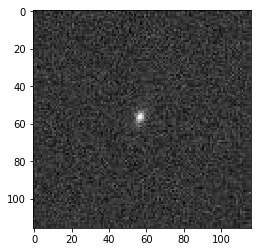

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(imgs[10000])

In [135]:
from keras.applications import vgg16

#image_batch = np.expand_dims(imgs, axis=0)

processed_image = vgg16.preprocess_input(np.array(imgs[1000:1100]))

In [136]:
pred_test = model.predict(processed_image)